In [1]:
#importing libraries

import numpy as np
import pandapower as pp
import pandas as pd
from pandapower import plotting
import matplotlib.pyplot as plt
from shapely.geometry import Point, LineString
import math

# Create empty net
net = pp.create_empty_network(f_hz=60)

In [2]:
#defining coordinate system

#Defining grid parameters in degrees
width=15
length=25
rd=10
grid_width=55
grid_length=60
angle=2*math.pi/360*15

#Defining reference point on earth
lat=-6.577178
long=-77.855809

# Defining coordinates of grid connection to Santos Tomas village
lat_ext=-6.576638522404465 #-6.5736824464455195
long_ext=-77.86268831193195 #-77.86323762912578

# Defining coordinates of hydro
lat_hyd=-6.570635
long_hyd= -77.830074

column=[]
row=[]
i=0
j=0

for i in range (0,6):
    column.append(rd+width+i*grid_width)
    column.append(rd+2*width+i*grid_width)
    i+=1

for j in range (0,6):
    row.append(rd+length+j*grid_length)
    j+=1


#defining spinnable dot web
#general case (x',y')=(math.cos(angle)*x-math.sin(angle)*y, math.cos(angle)*y+math.sin(angle)*x)

dot=[]
i=0
j=0

for j in range (0,6):
    for i in range (0,6):
        dot.append((long+(math.cos(angle)*column[i*2]-math.sin(angle)*row[j]), 
                    lat+(math.cos(angle)*row[j]+math.sin(angle)*column[i*2])))
        dot.append((long+(math.cos(angle)*column[i*2+1]-math.sin(angle)*row[j]), 
                    lat+(math.cos(angle)*row[j]+math.sin(angle)*column[i*2+1])))
        i+=1
    j+=1
    
    
#dot #array of coordinates of 72 dots in the grid

#dot[72] and dot[73] created for west and east transformers
x1=0
x2=rd+6*grid_width
y=rd/2+3*grid_length

#dot[72]
dot.append((long+(math.cos(angle)*x1-math.sin(angle)*y), 
            lat+(math.cos(angle)*y+math.sin(angle)*x1)))
#dot[73]
dot.append((long+(math.cos(angle)*x2-math.sin(angle)*y), 
            lat+(math.cos(angle)*y+math.sin(angle)*x2)))

In [3]:
#defining buses

V_ext_grid_kv = 22
V_trans_up_kv = 22
V_trans_down_kv = 0.415
V_house_kv = 0.415                                                              
                                              
# Load buses
bus = []
# For each 22kV/415V transformer, we create 36 buses, each accounting for one group of 3 houses fed by the the 3 phases
i=0
while i < 72 :
    bus.append(pp.create_bus(net, vn_kv=V_house_kv, name= 'Bus' + str(i), 
                             geodata=dot[i]))
    i+=1
    
# Transformers' buses    
# For each 22kV/415V transformer, we create two buses, one at 415V and one at 11kV

btrans_1_down = pp.create_bus(net, vn_kv=V_trans_down_kv, name= 'Transformer 1 down', geodata=dot[72])
btrans_1_up = pp.create_bus(net, vn_kv=V_trans_up_kv, name= 'Transformer 1 up', geodata=dot[72])
btrans_2_down = pp.create_bus(net, vn_kv=V_trans_down_kv, name= 'Transformer 2 down', geodata=dot[73])
btrans_2_up = pp.create_bus(net, vn_kv=V_trans_up_kv, name= 'Transformer 2 up', geodata=dot[73])   

# we now create one bus for the 22kV line we connect the village to 
b_ext_line = pp.create_bus(net, vn_kv=V_ext_grid_kv, name= 'Santos Tomas', geodata = (long_ext, lat_ext))

# bus for hydro
b_hydro = pp.create_bus(net, vn_kv=V_ext_grid_kv, name= 'Hydro', geodata = (long_hyd, lat_hyd))

In [4]:
#defining loads and transformers

# One load bus is made up of three houses, each house needing 1.5kW (ADMD for 18 houses). We consider a typical residential power factor of 0.9.
pfactor_bus = 0.9
p_bus_mw = 3.9e-3
p_school_mw = 19.5e-3
SF= 0.4843221048378526 #SF is defined Q=P*SF

#define 67 loads
i=0
while i < 67 :
    pp.create_load(net, bus=bus[i] , p_mw=p_bus_mw , q_mvar=p_bus_mw*SF , name= 'Load'+ str(i) )
    i+=1
    
#define school/charging station load bus, ie 68th load named 67 at bus 71
pp.create_load(net, bus=bus[71] , p_mw=p_school_mw , q_mvar=p_school_mw*SF , name= 'Load'+ str(67) )

# Creation of the 2 22kV/415V transformers
# Using parameters recommended by Malcolm

pp.create_transformer_from_parameters(net, hv_bus=btrans_1_up, lv_bus=btrans_1_down, sn_mva=0.2, vn_hv_kv=V_trans_up_kv, vn_lv_kv=V_trans_down_kv, vkr_percent=1, vk_percent=10, pfe_kw=0.25, i0_percent=0.33)
pp.create_transformer_from_parameters(net, hv_bus=btrans_2_up, lv_bus=btrans_2_down, sn_mva=0.2, vn_hv_kv=V_trans_up_kv, vn_lv_kv=V_trans_down_kv, vkr_percent=1, vk_percent=10, pfe_kw=0.25, i0_percent=0.33)


# Creation of the swingbus
pp.create_ext_grid(net, bus=b_ext_line, vm_pu=1.05, name='External grid')


# Creation of Hydro
#pp.create_gen(net, bus = b_hydro, p_mw = 0.45, vm_pu = 1.05, name = 'Hydro')
pp.create_sgen(net, bus = b_hydro, p_mw = 0.45, q_mvar=0.45*SF, name = 'Hydro')
#gen_solar = pp.create_sgen(net, bus = b_ll, p_mw = P_solar, q_mvar=0, name = "LLubi PV")

0

In [5]:
#define lines


#0.6/1kV XLPE Insulated Aerial Bundled Cables 4 Core Aluminium AS/NZS 3560.1. 50mm2

r_lv_ohm_per_km = 0.796                  #1.8769
x_lv_ohm_per_km = 0.1116 #=0.093/50*60   #0.35
c_lv_nf_per_km = 12.2                    #referenced from standard type line 48-AL1/8-ST1A 0.4
imax_lv_ka = 0.088                       #0.105
height_factor = 1.014                     #defined as real length=horizontal length*height factor

# distances are calculated from the grid layout
length_trans_line_1_km = 0.175*height_factor
length_trans_line_2_km = 0.115*height_factor
length_trans_line_3_km = 0.055*height_factor
length_trans_line_4_km = 0.055*height_factor
length_trans_line_5_km = 0.115*height_factor
length_trans_line_6_km = 0.175*height_factor

# creation of the six lines leaving each transformers
# Transformer 1
pp.create_line_from_parameters(net, from_bus = btrans_1_down , to_bus = bus[0] , length_km = length_trans_line_1_km, r_ohm_per_km = r_lv_ohm_per_km, x_ohm_per_km = x_lv_ohm_per_km, c_nf_per_km=c_lv_nf_per_km, max_i_ka=imax_lv_ka)
pp.create_line_from_parameters(net, from_bus = btrans_1_down , to_bus = bus[12] , length_km = length_trans_line_2_km, r_ohm_per_km = r_lv_ohm_per_km, x_ohm_per_km = x_lv_ohm_per_km, c_nf_per_km=c_lv_nf_per_km, max_i_ka=imax_lv_ka)
pp.create_line_from_parameters(net, from_bus = btrans_1_down , to_bus = bus[24] , length_km = length_trans_line_3_km, r_ohm_per_km = r_lv_ohm_per_km, x_ohm_per_km = x_lv_ohm_per_km, c_nf_per_km=c_lv_nf_per_km, max_i_ka=imax_lv_ka)
pp.create_line_from_parameters(net, from_bus = btrans_1_down , to_bus = bus[36] , length_km = length_trans_line_4_km, r_ohm_per_km = r_lv_ohm_per_km, x_ohm_per_km = x_lv_ohm_per_km, c_nf_per_km=c_lv_nf_per_km, max_i_ka=imax_lv_ka)
pp.create_line_from_parameters(net, from_bus = btrans_1_down , to_bus = bus[48] , length_km = length_trans_line_5_km, r_ohm_per_km = r_lv_ohm_per_km, x_ohm_per_km = x_lv_ohm_per_km, c_nf_per_km=c_lv_nf_per_km, max_i_ka=imax_lv_ka)
pp.create_line_from_parameters(net, from_bus = btrans_1_down , to_bus = bus[60] , length_km = length_trans_line_6_km, r_ohm_per_km = r_lv_ohm_per_km, x_ohm_per_km = x_lv_ohm_per_km, c_nf_per_km=c_lv_nf_per_km, max_i_ka=imax_lv_ka)

# Transformer 2
pp.create_line_from_parameters(net, from_bus = btrans_2_down , to_bus = bus[11] , length_km = length_trans_line_1_km, r_ohm_per_km = r_lv_ohm_per_km, x_ohm_per_km = x_lv_ohm_per_km, c_nf_per_km=c_lv_nf_per_km, max_i_ka=imax_lv_ka)
pp.create_line_from_parameters(net, from_bus = btrans_2_down , to_bus = bus[23] , length_km = length_trans_line_2_km, r_ohm_per_km = r_lv_ohm_per_km, x_ohm_per_km = x_lv_ohm_per_km, c_nf_per_km=c_lv_nf_per_km, max_i_ka=imax_lv_ka)
pp.create_line_from_parameters(net, from_bus = btrans_2_down , to_bus = bus[35] , length_km = length_trans_line_3_km, r_ohm_per_km = r_lv_ohm_per_km, x_ohm_per_km = x_lv_ohm_per_km, c_nf_per_km=c_lv_nf_per_km, max_i_ka=imax_lv_ka)
pp.create_line_from_parameters(net, from_bus = btrans_2_down , to_bus = bus[47] , length_km = length_trans_line_4_km, r_ohm_per_km = r_lv_ohm_per_km, x_ohm_per_km = x_lv_ohm_per_km, c_nf_per_km=c_lv_nf_per_km, max_i_ka=imax_lv_ka)
pp.create_line_from_parameters(net, from_bus = btrans_2_down , to_bus = bus[59] , length_km = length_trans_line_5_km, r_ohm_per_km = r_lv_ohm_per_km, x_ohm_per_km = x_lv_ohm_per_km, c_nf_per_km=c_lv_nf_per_km, max_i_ka=imax_lv_ka)
pp.create_line_from_parameters(net, from_bus = btrans_2_down , to_bus = bus[71] , length_km = length_trans_line_6_km, r_ohm_per_km = r_lv_ohm_per_km, x_ohm_per_km = x_lv_ohm_per_km, c_nf_per_km=c_lv_nf_per_km, max_i_ka=imax_lv_ka)


#defining lines between loads, with 2 modes, adjacent houses and houses divided by a road

#lines connecting adjacent houses
length1 = 0.015*height_factor
i=0
j=0

for j in range (0,5):
    for i in range (0,6):
        pp.create_line_from_parameters(net, from_bus = bus[i*2+j*12] , to_bus = bus[i*2+1+j*12] , length_km = length1, r_ohm_per_km = r_lv_ohm_per_km, x_ohm_per_km = x_lv_ohm_per_km, c_nf_per_km=c_lv_nf_per_km, max_i_ka=imax_lv_ka)
        i+=1
    j+=1
    
#lines connecting houses divided by road
length2 = 0.040*height_factor
i=0
j=0

for j in range (0,5):
    for i in range (0,2):
        pp.create_line_from_parameters(net, from_bus = bus[i*2+1+j*12] , to_bus = bus[i*2+2+j*12] , length_km = length2, r_ohm_per_km = r_lv_ohm_per_km, x_ohm_per_km = x_lv_ohm_per_km, c_nf_per_km=c_lv_nf_per_km, max_i_ka=imax_lv_ka)
        pp.create_line_from_parameters(net, from_bus = bus[(i+3)*2+1+j*12] , to_bus = bus[(i+3)*2+2+j*12] , length_km = length2, r_ohm_per_km = r_lv_ohm_per_km, x_ohm_per_km = x_lv_ohm_per_km, c_nf_per_km=c_lv_nf_per_km, max_i_ka=imax_lv_ka)
        i+=1
    j+=1

#lines for top row left
pp.create_line_from_parameters(net, from_bus = bus[60] , to_bus = bus[61] , length_km = length1, r_ohm_per_km = r_lv_ohm_per_km, x_ohm_per_km = x_lv_ohm_per_km, c_nf_per_km=c_lv_nf_per_km, max_i_ka=imax_lv_ka)
pp.create_line_from_parameters(net, from_bus = bus[61] , to_bus = bus[62] , length_km = length2, r_ohm_per_km = r_lv_ohm_per_km, x_ohm_per_km = x_lv_ohm_per_km, c_nf_per_km=c_lv_nf_per_km, max_i_ka=imax_lv_ka)
pp.create_line_from_parameters(net, from_bus = bus[62] , to_bus = bus[63] , length_km = length1, r_ohm_per_km = r_lv_ohm_per_km, x_ohm_per_km = x_lv_ohm_per_km, c_nf_per_km=c_lv_nf_per_km, max_i_ka=imax_lv_ka)
pp.create_line_from_parameters(net, from_bus = bus[63] , to_bus = bus[64] , length_km = length2, r_ohm_per_km = r_lv_ohm_per_km, x_ohm_per_km = x_lv_ohm_per_km, c_nf_per_km=c_lv_nf_per_km, max_i_ka=imax_lv_ka)
pp.create_line_from_parameters(net, from_bus = bus[64] , to_bus = bus[65] , length_km = length1, r_ohm_per_km = r_lv_ohm_per_km, x_ohm_per_km = x_lv_ohm_per_km, c_nf_per_km=c_lv_nf_per_km, max_i_ka=imax_lv_ka)
#pp.create_line_from_parameters(net, from_bus = bus[65] , to_bus = bus[66] , length_km = length2, r_ohm_per_km = r_lv_ohm_per_km, x_ohm_per_km = x_lv_ohm_per_km, c_nf_per_km=c_lv_nf_per_km, max_i_ka=imax_lv_ka)

#lines for top row right
pp.create_line_from_parameters(net, from_bus = bus[71] , to_bus = bus[66] , length_km = 0.125*height_factor, r_ohm_per_km = r_lv_ohm_per_km, x_ohm_per_km = x_lv_ohm_per_km, c_nf_per_km=c_lv_nf_per_km, max_i_ka=imax_lv_ka)



#22kV XLPE Insulated Non Metallic Screened ABC, 35mm2
r_hv_ohm_per_km = 1.11
x_hv_ohm_per_km = 0.161
c_hv_nf_per_km = 9.15           #referenced from standard type line 34-AL1/6-ST1A 20.0
imax_hv_ka = 0.11
height_factor_trans = 1.031           #defined as real length=horizontal length*height factor
    
pp.create_line_from_parameters(net, from_bus = b_ext_line , to_bus = btrans_1_up , length_km = 0.82*height_factor_trans, r_ohm_per_km = r_hv_ohm_per_km, x_ohm_per_km = x_hv_ohm_per_km, c_nf_per_km=c_hv_nf_per_km, max_i_ka=imax_hv_ka)
pp.create_line_from_parameters(net, from_bus = btrans_1_up , to_bus = btrans_2_up , length_km = 0.34*height_factor_trans, r_ohm_per_km = r_hv_ohm_per_km, x_ohm_per_km = x_hv_ohm_per_km, c_nf_per_km=c_hv_nf_per_km, max_i_ka=imax_hv_ka)
pp.create_line_from_parameters(net, from_bus = b_hydro , to_bus = b_ext_line , length_km = 3.67*height_factor_trans, r_ohm_per_km = r_hv_ohm_per_km, x_ohm_per_km = x_hv_ohm_per_km, c_nf_per_km=c_hv_nf_per_km, max_i_ka=imax_hv_ka)

#pp.create_line_from_parameters(net, from_bus = b_hydro , to_bus = btrans_1_up , length_km = length_hv_line_km, r_ohm_per_km = r_hv_ohm_per_km, x_ohm_per_km = x_hv_ohm_per_km, c_nf_per_km=c_hv_nf_per_km, max_i_ka=imax_hv_ka)
#pp.create_line_from_parameters(net, from_bus = btrans_1_up , to_bus = btrans_2_up , length_km = length_hv_line_km, r_ohm_per_km = r_hv_ohm_per_km, x_ohm_per_km = x_hv_ohm_per_km, c_nf_per_km=c_hv_nf_per_km, max_i_ka=imax_hv_ka)


#net.line.tail(50)



70

In [6]:
pp.runpp(net);

#pp.diagnostic(net, report_style='detailed', warnings_only=False, return_result_dict=True, overload_scaling_factor=0.001, min_r_ohm=0.001, min_x_ohm=0.001, min_r_pu=1e-05, min_x_pu=1e-05, nom_voltage_tolerance=0.3, numba_tolerance=1e-05) ;



In [7]:
net.res_line

pp.to_excel(net, 'perutownPP.xlsx')
#l=(length_hv_array[0]+length_hv_array[1]+length_hv_array[2]+length_hv_array[3])*4
#print(l)

#l=(length_array[0]+length_array[1]+length_array[2]+length_array[3]+length_array[4])*16
#print(l)

#net.res_bus.head()


In [8]:
#net.line.head(24)

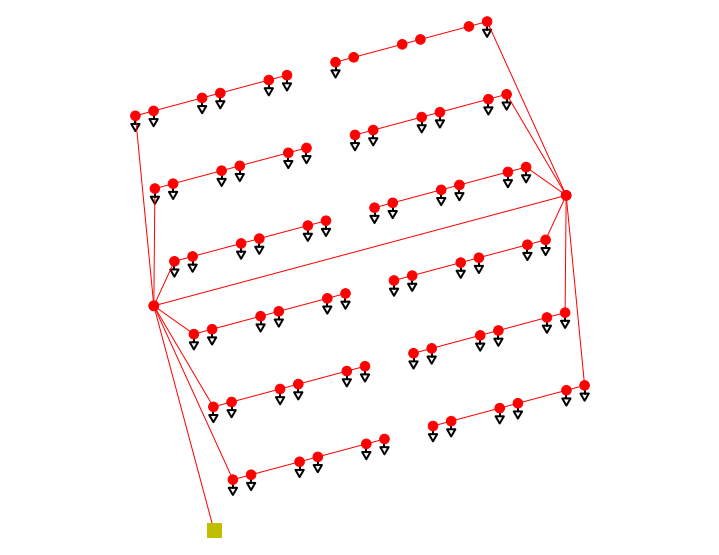

<AxesSubplot:>

In [11]:
pp.plotting.simple_plot(net, respect_switches=False, line_width=1.0, bus_size=1.0, ext_grid_size=1.0, trafo_size=1.0, \
                     plot_loads=True, plot_sgens=False, load_size=1.0, sgen_size=3.0, switch_size=1.0, switch_distance=1.0, plot_line_switches=False, scale_size=True, bus_color='r', line_color='red', trafo_color='k', ext_grid_color='y',switch_color='k', library='igraph', show_plot=True, ax=None)